### Dataset and DataLoaders

In [20]:
import json, os, torch, cv2, numpy as np, albumentations as A
from PIL import Image; from matplotlib import pyplot as plt
from glob import glob
from torch.utils.data import random_split, Dataset, DataLoader
from albumentations.pytorch import ToTensorV2

class CustomSegmentationDataset(Dataset):
    
    def __init__(self, root, transformations = None):

        self.im_paths = sorted(glob(f"{root}/*/images/*.jpg"))
        self.gt_paths = sorted(glob(f"{root}/*/masks/*.png"))
        self.transformations = transformations
        self.n_cls = 5
        
        assert len(self.im_paths) == len(self.gt_paths)
        
    def __len__(self): return len(self.im_paths)

    def __getitem__(self, idx):
        
        im, gt = self.get_im_gt(self.im_paths[idx], self.gt_paths[idx])
        
        if self.transformations: im, gt = self.apply_transformations(im, gt)
        
        return im, gt
        
    def get_im_gt(self, im_path, gt_path): return self.read_im(im_path), self.read_im(gt_path)

    def read_im(self, path): return cv2.cvtColor(cv2.imread(path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)

    def apply_transformations(self, im, gt): transformed = self.transformations(image = im, mask = gt); return transformed["image"], transformed["mask"]

def get_dls(root, transformations, bs, split = [0.9, 0.05, 0.05]):
        
    assert sum(split) == 1., "Sum of the split must be exactly 1"
    
    ds = CustomSegmentationDataset(root = root, transformations = transformations)
    n_cls = ds.n_cls
    
    tr_len = int(len(ds) * split[0])
    val_len = int(len(ds) * split[1])
    test_len = len(ds) - (tr_len + val_len)
    
    # Data split
    tr_ds, val_ds, test_ds = torch.utils.data.random_split(ds, [tr_len, val_len, test_len])
        
    print(f"\nThere are {len(tr_ds)} number of images in the train set")
    print(f"There are {len(val_ds)} number of images in the validation set")
    print(f"There are {len(test_ds)} number of images in the test set\n")
    
    # Get dataloaders
    tr_dl  = DataLoader(dataset = tr_ds, batch_size = bs, shuffle = True, num_workers = 8)
    val_dl = DataLoader(dataset = val_ds, batch_size = bs, shuffle = False, num_workers = 8)
    test_dl = DataLoader(dataset = test_ds, batch_size = 1, shuffle = True, num_workers = 8)
    
    
    return tr_dl, val_dl, test_dl, n_cls

root = "/home/mrson/python_code/hoc_deeplearning/MiAI_Defect_Detection/Semantic_segmentation_dataset"
mean, std, im_h, im_w = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 256, 256
trans = A.Compose( [A.Resize(im_h, im_w), A.augmentations.transforms.Normalize(mean = mean, std = std), ToTensorV2(transpose_mask = True) ])
tr_dl, val_dl, test_dl, n_cls = get_dls(root = root, transformations = trans, bs = 4)
print(test_dl)


There are 64 number of images in the train set
There are 3 number of images in the validation set
There are 5 number of images in the test set



### Visualization

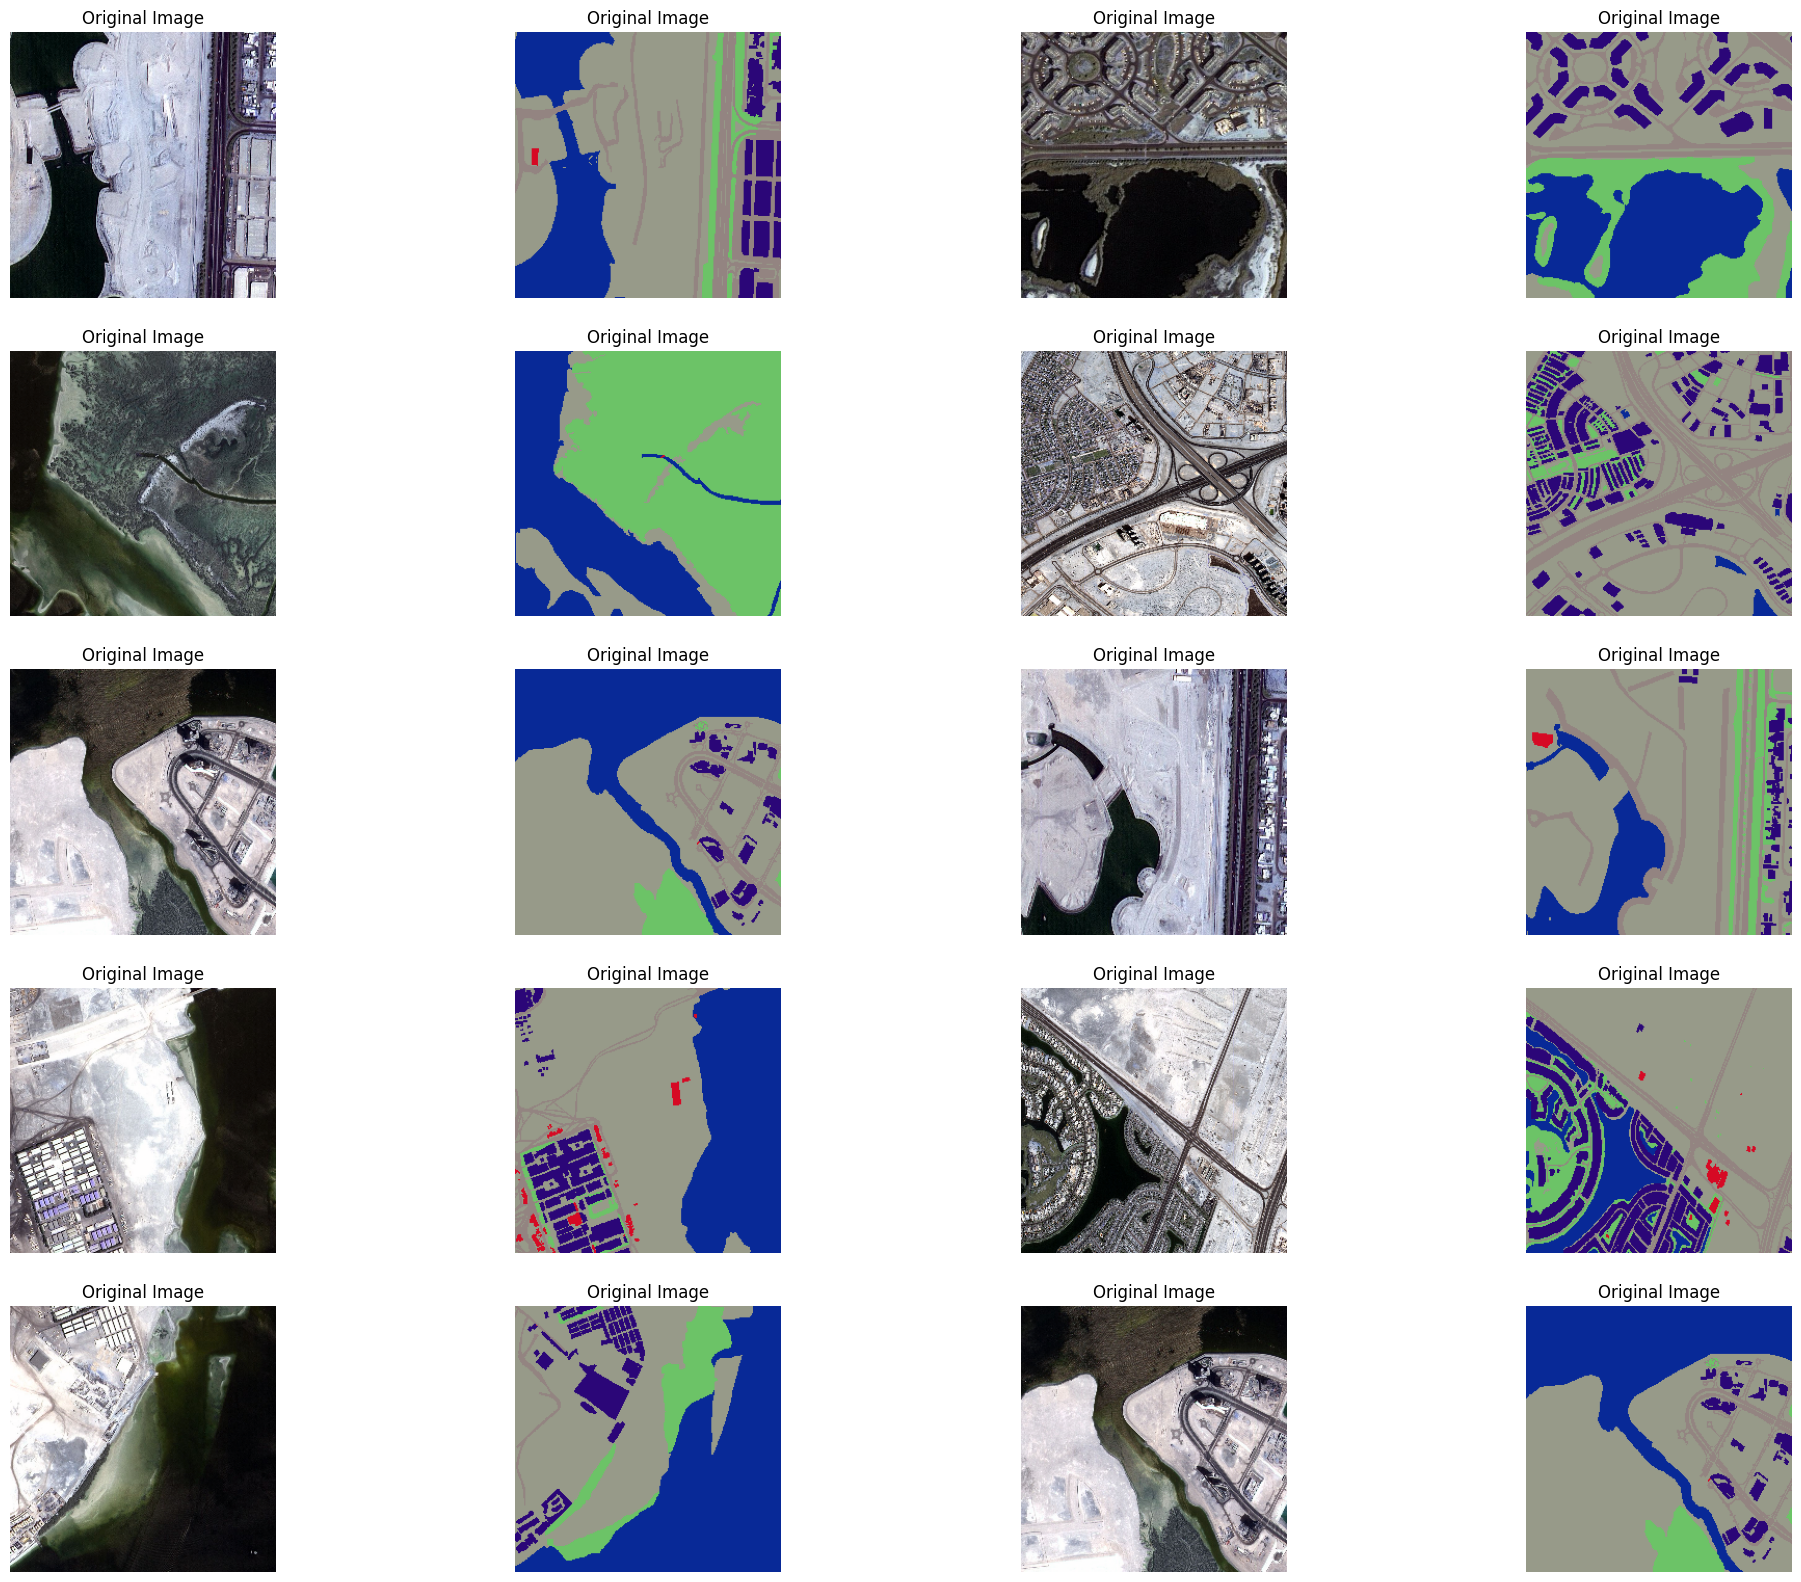

In [2]:
import random
from torchvision import transforms as tfs

def tn_2_np(t): 
    invTrans = tfs.Compose([ tfs.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                tfs.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]) ])
    
    rgb = True if len(t) == 3 else False
    
    return (invTrans(t) * 255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8) if rgb else (t*255).detach().cpu().numpy().astype(np.uint8)

def plot(rows, cols, count, im, gt = None, title = "Original Image"):
    
    plt.subplot(rows, cols, count)
    plt.imshow(tn_2_np(im.squeeze(0).float())) if gt else plt.imshow(tn_2_np(im.squeeze(0)))
    plt.axis("off"); plt.title(title)
    
    return count + 1

def visualize(ds, n_ims):
    
    plt.figure(figsize = (25, 20))
    rows = n_ims // 4; cols = n_ims // rows
    count = 1
    indices = [random.randint(0, len(ds) - 1) for _ in range(n_ims)]
    
    for idx, index in enumerate(indices):
        
        if count == n_ims + 1: break
        im, gt = ds[index]
        
        # First Plot
        count = plot(rows, cols, count, im = im)
        
        # Second Plot
        count = plot(rows, cols, count, im = gt, gt = True)
        
visualize(tr_dl.dataset, n_ims = 20)

### Training Setup

In [3]:
# !pip install segmentation_models_pytorch
import segmentation_models_pytorch as smp

model = smp.DeepLabV3Plus(classes = n_cls)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 3e-4)

import time
from tqdm import tqdm
from torch.nn import functional as F

class Metrics():
    
    def __init__(self, pred, gt, loss_fn, eps = 1e-10, n_cls = 2):
        
        self.pred, self.gt = torch.argmax(F.softmax(pred, dim=1), dim = 1), gt # (batch, width, height)
        self.loss_fn, self.eps, self.n_cls, self.pred_ = loss_fn, eps, n_cls, pred
        
    def to_contiguous(self, inp): return inp.contiguous().view(-1) 
    
    def PA(self):

        with torch.no_grad():
            match = torch.eq(self.pred, self.gt).int()
        
        return float(match.sum()) / float(match.numel())

    def mIoU(self):
        
        with torch.no_grad():
            self.gt = torch.argmax(self.gt, dim = 1)
            
            pred, gt = self.to_contiguous(self.pred), self.to_contiguous(self.gt)

            iou_per_class = []
            
            for c in range(self.n_cls):
                
                match_pred = pred == c
                match_gt   = gt == c

                if match_gt.long().sum().item() == 0: iou_per_class.append(np.nan)
                    
                else:
                    
                    intersect = torch.logical_and(match_pred, match_gt).sum().float().item()
                    union = torch.logical_or(match_pred, match_gt).sum().float().item()

                    iou = (intersect + self.eps) / (union + self.eps)
                    iou_per_class.append(iou)
                    
            return np.nanmean(iou_per_class)
    
    def loss(self): return self.loss_fn(self.pred_, torch.argmax(self.gt, dim = 1))

def tic_toc(start_time = None): return time.time() if start_time == None else time.time() - start_time

### Train and Validation

In [4]:
def train(model, tr_dl, val_dl, loss_fn, opt, device, epochs, save_prefix, save_path = "saved_models"):
    
    tr_loss, tr_pa, tr_iou = [], [], []
    val_loss, val_pa, val_iou = [], [], []
    tr_len, val_len = len(tr_dl), len(val_dl)
    best_loss, decrease, not_improve, early_stop_threshold = np.inf, 1, 0, 7
    os.makedirs(save_path, exist_ok=True)

    model.to(device)
    train_start = tic_toc()
    print("Start training process...")
    
    for epoch in range(1, epochs + 1):
        tic = tic_toc()
        tr_loss_, tr_iou_, tr_pa_ = 0, 0, 0
        
        model.train()
        print(f"Epoch {epoch} train process is started...")
        for idx, batch in enumerate(tqdm(tr_dl)):
            
            ims, gts = batch
            ims, gts = ims.to(device), gts.to(device)
            
            preds = model(ims)
            
            met = Metrics(preds, gts, loss_fn, n_cls = n_cls)
            loss_ = met.loss()
            
            tr_iou_ += met.mIoU()
            
            tr_pa_ += met.PA()
            tr_loss_ += loss_.item()
            
            loss_.backward()
            opt.step()
            opt.zero_grad()
        
        print(f"Epoch {epoch} validation process is started...")
        model.eval()
        val_loss_, val_iou_, val_pa_ = 0, 0, 0

        with torch.no_grad():
            for idx, batch in enumerate(tqdm(val_dl)):

                ims, gts = batch
                ims, gts = ims.to(device), gts.to(device)

                preds = model(ims)

                met = Metrics(preds, gts, loss_fn, n_cls = n_cls)

                val_loss_ += met.loss().item()
                val_iou_ += met.mIoU()
                val_pa_ += met.PA()
                

        print(f"Epoch {epoch} train process is completed.")

        tr_loss_ /= tr_len
        tr_iou_ /= tr_len
        tr_pa_ /= tr_len

        val_loss_ /= val_len
        val_iou_ /=  val_len
        val_pa_ /=   val_len

        print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print(f"\nEpoch {epoch} train process results: \n")
        print(f"Train Time         -> {tic_toc(tic):.3f} secs")
        print(f"Train Loss         -> {tr_loss_:.3f}")
        print(f"Train PA           -> {tr_pa_:.3f}")
        print(f"Train IoU          -> {tr_iou_:.3f}")
        print(f"Validation Loss    -> {val_loss_:.3f}")
        print(f"Validation PA      -> {val_pa_:.3f}")
        print(f"Validation IoU     -> {val_iou_:.3f}\n")

        tr_loss.append(tr_loss_)
        tr_iou.append(tr_iou_)
        tr_pa.append(tr_pa_)

        val_loss.append(val_loss_)
        val_iou.append(val_iou_)
        val_pa.append(val_pa_)
        
        if best_loss > (val_loss_):
            print(f"Loss decreased from {best_loss:.3f} to {val_loss_:.3f}!")
            best_loss = val_loss_
            decrease += 1
            if decrease % 2 == 0:
                print("Saving the model with the best loss value...")
                torch.save(model, f"{save_path}/{save_prefix}_best_model.pt")

        if val_loss_ > best_loss:

            not_improve += 1
            best_loss = val_loss_
            print(f"Loss did not decrease for {not_improve} epoch(s)!")
            if not_improve == early_stop_threshold:
                print(f"Stopping training process becuase loss value did not decrease for {early_stop_threshold} epochs!")
                break
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
            
    print(f"Train process is completed in {(tic_toc(train_start)) / 60:.3f} minutes.")
    
    return {"tr_loss": tr_loss, "tr_iou": tr_iou, "tr_pa": tr_pa,
            "val_loss": val_loss, "val_iou": val_iou, "val_pa" : val_pa}

device = "cuda" if torch.cuda.is_available() else "cpu"

history = train(model = model, tr_dl = tr_dl, val_dl = val_dl,
                 loss_fn = loss_fn, opt = optimizer, device = device,
                 epochs = 50, save_prefix = "aerial")

Start training process...
Epoch 1 train process is started...


100%|██████████| 16/16 [00:01<00:00,  8.92it/s]


Epoch 1 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


Epoch 1 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 1 train process results: 

Train Time         -> 2.112 secs
Train Loss         -> 1.060
Train PA           -> 0.704
Train IoU          -> 0.572
Validation Loss    -> 1.301
Validation PA      -> 0.924
Validation IoU     -> 0.820

Loss decreased from inf to 1.301!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 2 train process is started...


100%|██████████| 16/16 [00:01<00:00, 15.22it/s]


Epoch 2 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  3.40it/s]


Epoch 2 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 2 train process results: 

Train Time         -> 1.351 secs
Train Loss         -> 0.584
Train PA           -> 0.843
Train IoU          -> 0.703
Validation Loss    -> 0.769
Validation PA      -> 0.846
Validation IoU     -> 0.699

Loss decreased from 1.301 to 0.769!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 3 train process is started...


100%|██████████| 16/16 [00:01<00:00, 15.28it/s]


Epoch 3 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


Epoch 3 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 3 train process results: 

Train Time         -> 1.343 secs
Train Loss         -> 0.469
Train PA           -> 0.874
Train IoU          -> 0.747
Validation Loss    -> 0.247
Validation PA      -> 0.950
Validation IoU     -> 0.872

Loss decreased from 0.769 to 0.247!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 4 train process is started...


100%|██████████| 16/16 [00:01<00:00, 15.60it/s]


Epoch 4 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


Epoch 4 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 4 train process results: 

Train Time         -> 1.343 secs
Train Loss         -> 0.307
Train PA           -> 0.917
Train IoU          -> 0.821
Validation Loss    -> 0.181
Validation PA      -> 0.953
Validation IoU     -> 0.883

Loss decreased from 0.247 to 0.181!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 5 train process is started...


100%|██████████| 16/16 [00:01<00:00, 15.95it/s]


Epoch 5 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


Epoch 5 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 5 train process results: 

Train Time         -> 1.305 secs
Train Loss         -> 0.331
Train PA           -> 0.897
Train IoU          -> 0.773
Validation Loss    -> 0.166
Validation PA      -> 0.953
Validation IoU     -> 0.883

Loss decreased from 0.181 to 0.166!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 6 train process is started...


100%|██████████| 16/16 [00:00<00:00, 16.20it/s]


Epoch 6 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  3.47it/s]


Epoch 6 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 6 train process results: 

Train Time         -> 1.280 secs
Train Loss         -> 0.290
Train PA           -> 0.915
Train IoU          -> 0.806
Validation Loss    -> 0.144
Validation PA      -> 0.954
Validation IoU     -> 0.883

Loss decreased from 0.166 to 0.144!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 7 train process is started...


100%|██████████| 16/16 [00:01<00:00, 15.96it/s]


Epoch 7 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


Epoch 7 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 7 train process results: 

Train Time         -> 1.308 secs
Train Loss         -> 0.219
Train PA           -> 0.931
Train IoU          -> 0.845
Validation Loss    -> 0.138
Validation PA      -> 0.958
Validation IoU     -> 0.895

Loss decreased from 0.144 to 0.138!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 8 train process is started...


100%|██████████| 16/16 [00:01<00:00, 15.35it/s]


Epoch 8 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  3.40it/s]


Epoch 8 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 8 train process results: 

Train Time         -> 1.340 secs
Train Loss         -> 0.211
Train PA           -> 0.932
Train IoU          -> 0.845
Validation Loss    -> 0.131
Validation PA      -> 0.960
Validation IoU     -> 0.901

Loss decreased from 0.138 to 0.131!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 9 train process is started...


100%|██████████| 16/16 [00:01<00:00, 14.21it/s]


Epoch 9 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  3.47it/s]


Epoch 9 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 9 train process results: 

Train Time         -> 1.417 secs
Train Loss         -> 0.223
Train PA           -> 0.928
Train IoU          -> 0.835
Validation Loss    -> 0.129
Validation PA      -> 0.958
Validation IoU     -> 0.892

Loss decreased from 0.131 to 0.129!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 10 train process is started...


100%|██████████| 16/16 [00:01<00:00, 15.85it/s]


Epoch 10 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  3.45it/s]


Epoch 10 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 10 train process results: 

Train Time         -> 1.304 secs
Train Loss         -> 0.201
Train PA           -> 0.938
Train IoU          -> 0.852
Validation Loss    -> 0.117
Validation PA      -> 0.960
Validation IoU     -> 0.899

Loss decreased from 0.129 to 0.117!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 11 train process is started...


100%|██████████| 16/16 [00:01<00:00, 15.09it/s]


Epoch 11 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  3.45it/s]


Epoch 11 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 11 train process results: 

Train Time         -> 1.353 secs
Train Loss         -> 0.171
Train PA           -> 0.944
Train IoU          -> 0.871
Validation Loss    -> 0.116
Validation PA      -> 0.964
Validation IoU     -> 0.908

Loss decreased from 0.117 to 0.116!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 12 train process is started...


100%|██████████| 16/16 [00:01<00:00, 14.52it/s]


Epoch 12 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  3.42it/s]


Epoch 12 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 12 train process results: 

Train Time         -> 1.399 secs
Train Loss         -> 0.197
Train PA           -> 0.934
Train IoU          -> 0.843
Validation Loss    -> 0.119
Validation PA      -> 0.959
Validation IoU     -> 0.895

Loss did not decrease for 1 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 13 train process is started...


100%|██████████| 16/16 [00:00<00:00, 16.53it/s]


Epoch 13 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


Epoch 13 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 13 train process results: 

Train Time         -> 1.268 secs
Train Loss         -> 0.170
Train PA           -> 0.944
Train IoU          -> 0.864
Validation Loss    -> 0.111
Validation PA      -> 0.964
Validation IoU     -> 0.908

Loss decreased from 0.119 to 0.111!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 14 train process is started...


100%|██████████| 16/16 [00:01<00:00, 15.25it/s]


Epoch 14 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  3.44it/s]


Epoch 14 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 14 train process results: 

Train Time         -> 1.345 secs
Train Loss         -> 0.174
Train PA           -> 0.943
Train IoU          -> 0.866
Validation Loss    -> 0.122
Validation PA      -> 0.960
Validation IoU     -> 0.900

Loss did not decrease for 2 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 15 train process is started...


100%|██████████| 16/16 [00:01<00:00, 15.45it/s]


Epoch 15 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


Epoch 15 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 15 train process results: 

Train Time         -> 1.352 secs
Train Loss         -> 0.167
Train PA           -> 0.944
Train IoU          -> 0.862
Validation Loss    -> 0.118
Validation PA      -> 0.958
Validation IoU     -> 0.893

Loss decreased from 0.122 to 0.118!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 16 train process is started...


100%|██████████| 16/16 [00:01<00:00, 15.04it/s]


Epoch 16 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


Epoch 16 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 16 train process results: 

Train Time         -> 1.369 secs
Train Loss         -> 0.142
Train PA           -> 0.950
Train IoU          -> 0.885
Validation Loss    -> 0.106
Validation PA      -> 0.961
Validation IoU     -> 0.902

Loss decreased from 0.118 to 0.106!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 17 train process is started...


100%|██████████| 16/16 [00:01<00:00, 15.73it/s]


Epoch 17 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


Epoch 17 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 17 train process results: 

Train Time         -> 1.317 secs
Train Loss         -> 0.148
Train PA           -> 0.949
Train IoU          -> 0.879
Validation Loss    -> 0.109
Validation PA      -> 0.962
Validation IoU     -> 0.903

Loss did not decrease for 3 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 18 train process is started...


100%|██████████| 16/16 [00:01<00:00, 15.90it/s]


Epoch 18 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


Epoch 18 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 18 train process results: 

Train Time         -> 1.314 secs
Train Loss         -> 0.153
Train PA           -> 0.949
Train IoU          -> 0.876
Validation Loss    -> 0.120
Validation PA      -> 0.961
Validation IoU     -> 0.903

Loss did not decrease for 4 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 19 train process is started...


100%|██████████| 16/16 [00:00<00:00, 16.11it/s]


Epoch 19 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


Epoch 19 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 19 train process results: 

Train Time         -> 1.309 secs
Train Loss         -> 0.148
Train PA           -> 0.951
Train IoU          -> 0.877
Validation Loss    -> 0.108
Validation PA      -> 0.963
Validation IoU     -> 0.905

Loss decreased from 0.120 to 0.108!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 20 train process is started...


100%|██████████| 16/16 [00:01<00:00, 15.35it/s]


Epoch 20 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  3.47it/s]


Epoch 20 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 20 train process results: 

Train Time         -> 1.335 secs
Train Loss         -> 0.129
Train PA           -> 0.953
Train IoU          -> 0.891
Validation Loss    -> 0.121
Validation PA      -> 0.963
Validation IoU     -> 0.909

Loss did not decrease for 5 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 21 train process is started...


100%|██████████| 16/16 [00:01<00:00, 14.94it/s]


Epoch 21 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


Epoch 21 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 21 train process results: 

Train Time         -> 1.384 secs
Train Loss         -> 0.141
Train PA           -> 0.949
Train IoU          -> 0.875
Validation Loss    -> 0.121
Validation PA      -> 0.963
Validation IoU     -> 0.908

Loss decreased from 0.121 to 0.121!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 22 train process is started...


100%|██████████| 16/16 [00:00<00:00, 16.37it/s]


Epoch 22 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


Epoch 22 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 22 train process results: 

Train Time         -> 1.276 secs
Train Loss         -> 0.133
Train PA           -> 0.954
Train IoU          -> 0.885
Validation Loss    -> 0.108
Validation PA      -> 0.962
Validation IoU     -> 0.903

Loss decreased from 0.121 to 0.108!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 23 train process is started...


100%|██████████| 16/16 [00:01<00:00, 15.65it/s]


Epoch 23 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


Epoch 23 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 23 train process results: 

Train Time         -> 1.322 secs
Train Loss         -> 0.124
Train PA           -> 0.954
Train IoU          -> 0.891
Validation Loss    -> 0.119
Validation PA      -> 0.961
Validation IoU     -> 0.903

Loss did not decrease for 6 epoch(s)!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 24 train process is started...


100%|██████████| 16/16 [00:01<00:00, 15.78it/s]


Epoch 24 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


Epoch 24 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 24 train process results: 

Train Time         -> 1.317 secs
Train Loss         -> 0.134
Train PA           -> 0.952
Train IoU          -> 0.878
Validation Loss    -> 0.112
Validation PA      -> 0.964
Validation IoU     -> 0.909

Loss decreased from 0.119 to 0.112!
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 25 train process is started...


100%|██████████| 16/16 [00:00<00:00, 16.18it/s]


Epoch 25 validation process is started...


100%|██████████| 1/1 [00:00<00:00,  3.43it/s]

Epoch 25 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 25 train process results: 

Train Time         -> 1.286 secs
Train Loss         -> 0.171
Train PA           -> 0.944
Train IoU          -> 0.849
Validation Loss    -> 0.123
Validation PA      -> 0.956
Validation IoU     -> 0.888

Loss did not decrease for 7 epoch(s)!
Stopping training process becuase loss value did not decrease for 7 epochs!
Train process is completed in 0.593 minutes.


### Learning Curves

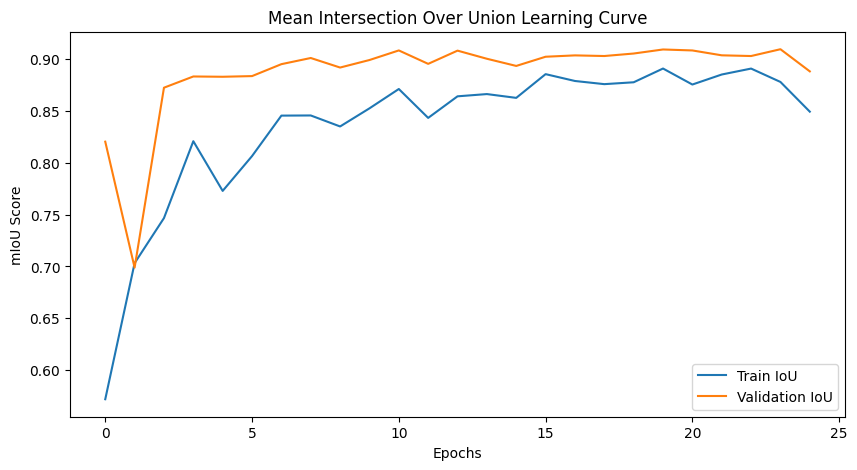

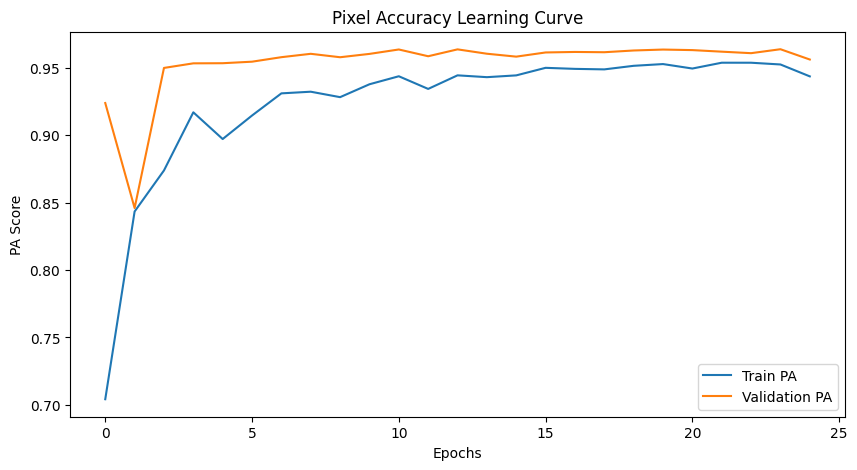

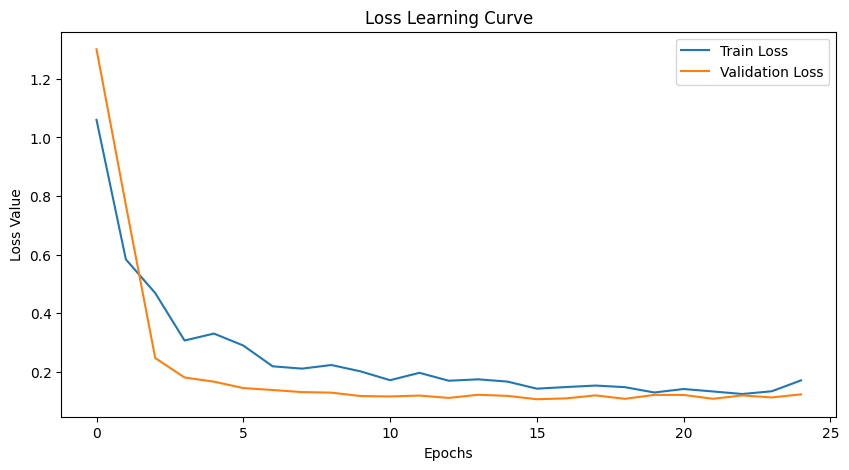

In [5]:
class Plot():
    
    def __init__(self, res):
        
        self.res = res
        
        self.visualize(metric1 = "tr_iou", metric2 = "val_iou", label1 = "Train IoU", 
                  label2 = "Validation IoU", title = "Mean Intersection Over Union Learning Curve", ylabel = "mIoU Score")
    
        self.visualize(metric1 = "tr_pa", metric2 = "val_pa", label1 = "Train PA", 
                  label2 = "Validation PA", title = "Pixel Accuracy Learning Curve", ylabel = "PA Score")
        
        self.visualize(metric1 = "tr_loss", metric2 = "val_loss", label1 = "Train Loss", 
                  label2 = "Validation Loss", title = "Loss Learning Curve", ylabel = "Loss Value")
        
        
    def plot(self, metric, label): plt.plot(self.res[metric], label = label)
    
    def decorate(self, ylabel, title): plt.title(title); plt.xlabel("Epochs"); plt.ylabel(ylabel); plt.legend(); plt.show()
    
    def visualize(self, metric1, metric2, label1, label2, title, ylabel):
        
        plt.figure(figsize=(10, 5))
        self.plot(metric1, label1); self.plot(metric2, label2)
        self.decorate(ylabel, title)                
        
Plot(history)

### Inference

/tmp/ipykernel_145142/1268334673.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(dir_model)


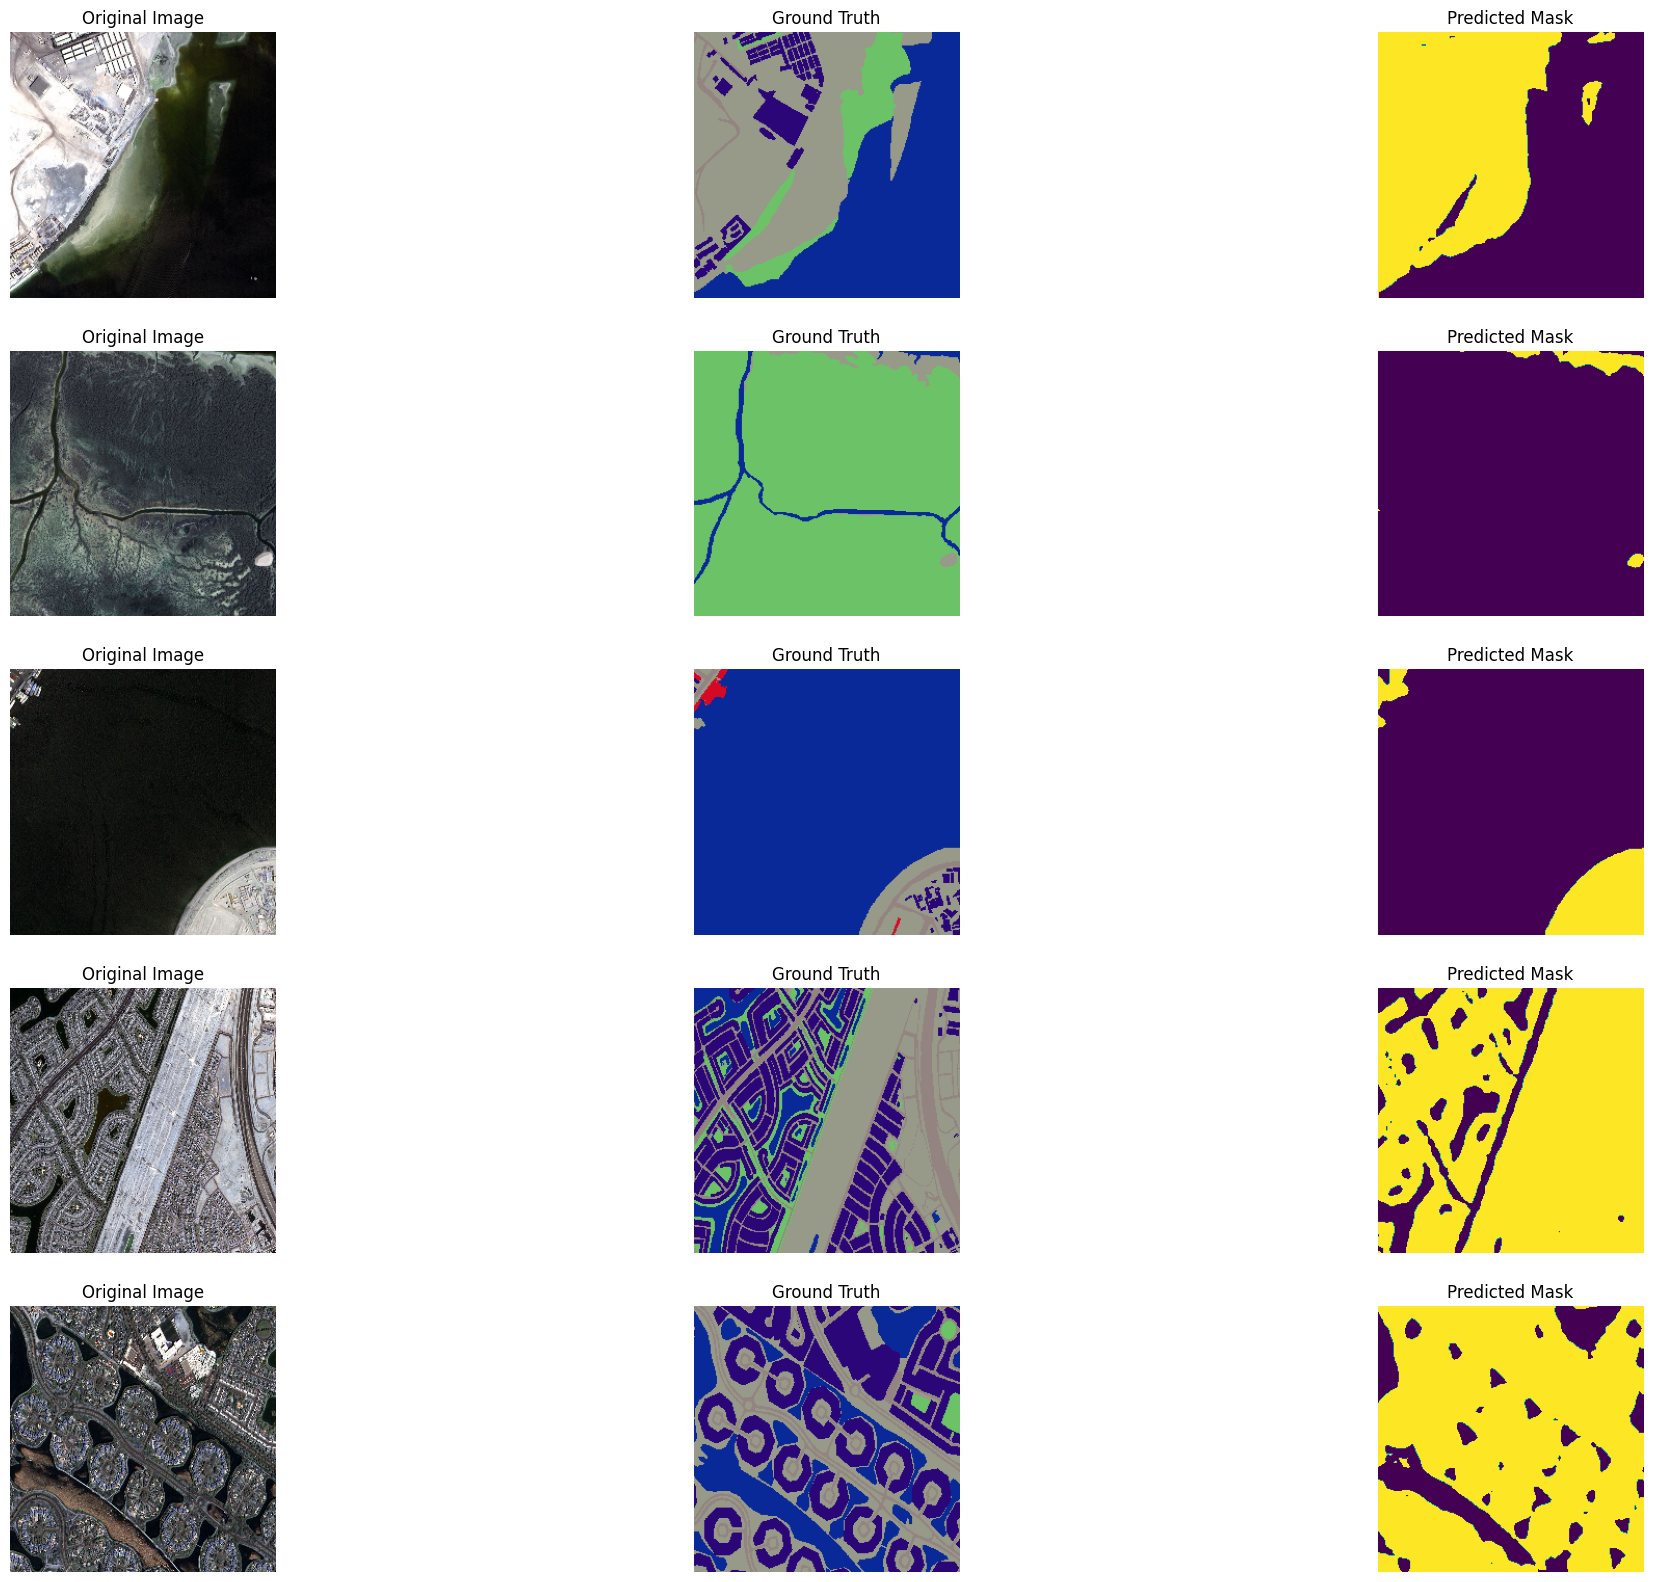

In [21]:
def inference(dl, model, device, n_ims = 15):
    
    cols = n_ims // 3; rows = n_ims // cols
    
    count = 1
    ims, gts, preds = [], [], []
    for idx, data in enumerate(dl):
        im, gt = data

        # Get predicted mask
        with torch.no_grad(): pred = torch.argmax(model(im.to(device)), dim = 1)
        ims.append(im); gts.append(gt); preds.append(pred)
        
    plt.figure(figsize = (25, 20))
    for idx, (im, gt, pred) in enumerate(zip(ims, gts, preds)):
        if idx == cols: break
        
        # First plot
        count = plot(cols, rows, count, im)

        # Second plot
        count = plot(cols, rows, count, im = gt, gt = True, title = "Ground Truth")

        # Third plot
        count = plot(cols, rows, count, im = pred, title = "Predicted Mask")
dir_model="/home/mrson/python_code/hoc_deeplearning/MiAI_Defect_Detection/models/aerial_best_model.pt"
model = torch.load(dir_model)
inference(test_dl, model = model, device = device)